In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import pickle as pk
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/afs/csail.mit.edu/u/s/samsl/Work/Adapting_PLM_DTI')
DATA_DIR = '/afs/csail.mit.edu/u/s/samsl/Work/databases/MoleculeNet/'

## Tox21

In [608]:
df = pd.read_csv(f'{DATA_DIR}/tox21.csv')
task_names = df.columns[:12]

In [609]:
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [635]:
from numpy.random import choice

In [671]:
from itertools import combinations
from scipy.special import comb

dfi = df.set_index('smiles').drop('mol_id',axis=1)
jacc_s = []
cos_sim = []
cos_morgan = []

n_random = 100000
rand_pairs = list(zip(choice(dfi.index,n_random), choice(dfi.index,n_random)))

for (sma, smb) in tqdm(rand_pairs,total=n_random):
    jnt_df = dfi.loc[[sma,smb],:].dropna(axis=1)
    js = jaccard_score(jnt_df.iloc[0].values, jnt_df.iloc[1].values)
    if (js > 0) & (jnt_df.shape[1] > 0):
        jacc_s.append(js)
        cos_sim.append(cosine_similarity(torch.from_numpy(drug_projections[sma]), torch.from_numpy(drug_projections[smb])).detach().cpu().item())
        cos_morgan.append(cosine_similarity(torch.from_numpy(drug_morgans[sma]), torch.from_numpy(drug_morgans[smb])).detach().cpu().item())

  0%|          | 0/100000 [00:00<?, ?it/s]

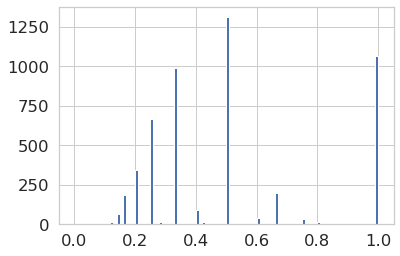

In [672]:
plt.hist(jacc_s,bins=np.arange(0,1.01,0.01))
plt.show()

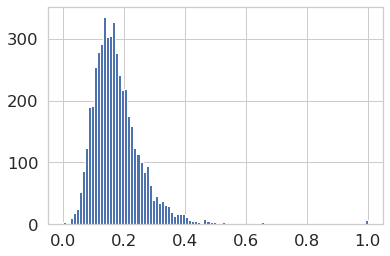

In [673]:
plt.hist(cos_sim,bins=np.arange(0,1.01,0.01))
plt.show()

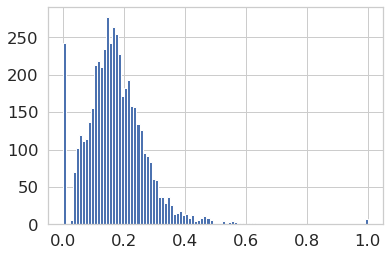

In [674]:
plt.hist(cos_morgan,bins=np.arange(0,1.01,0.01))
plt.show()

Text(0.5, 1.0, 'spearmanr=6.903E-02, (p=8.908E-07)')

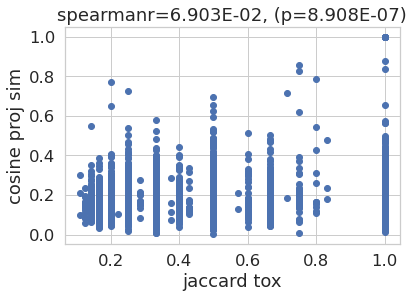

In [678]:
from scipy.stats import pearsonr, spearmanr

r,p = spearmanr(jacc_s, cos_sim)

plt.scatter(jacc_s, cos_sim)
plt.xlabel('jaccard tox')
plt.ylabel('cosine proj sim')
plt.title(f'spearmanr={r:.3E}, (p={p:.3E})')

Text(0.5, 1.0, 'spearmanr=4.885E-02, (p=5.098E-04)')

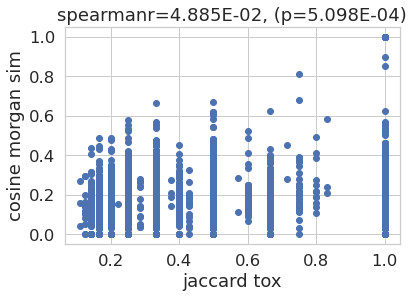

In [679]:
from scipy.stats import pearsonr, spearmanr

r,p = spearmanr(jacc_s, cos_morgan)

plt.scatter(jacc_s, cos_morgan)
plt.xlabel('jaccard tox')
plt.ylabel('cosine morgan sim')
plt.title(f'spearmanr={r:.3E}, (p={p:.3E})')

In [238]:
# based on https://pubchem.ncbi.nlm.nih.gov/bioassay/[0] and https://pubchem.ncbi.nlm.nih.gov/protein/[1]#section=Sequence

task2sequence = {
    'NR-AR': (743040, 'https://pubchem.ncbi.nlm.nih.gov/protein/AAI32976.1', 'AAI32976.1', 'MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGSPQAHRRGPTGYLVLDEEQQPSQPQSALECHPERGCVPEPGAAVAASKGLPQQLPAPPDEDDSAAPSTLSLLGPTFPGLSSCSADLKDILSEASTMQLLQQQQQEAVSEGSSSGRAREASGAPTSSKDNYLGGTSTISDNAKELCKAVSVSMGLGVEALEHLSPGEQLRGDCMYAPLLGVPPAVRPTPCAPLAECKGSLLDDSAGKSTEDTAEYSPFKGGYTKGLEGESLGCSGSAAAGSSGTLELPSTLSLYKSGALDEAAAYQSRDYYNFPLALAGPPPPPPPPHPHARIKLENPLDYGSAWAAAAAQCRYGDLASLHGAGAAGPGSGSPSAAASSSWHTLFTAEEGQLYGPCGGGGGGGGGGGGGGGGGGGEAGAVAPYGYTRPPQGLAGQESDFTAPDVWYPGGMVSRVPYPSPTCVKSEMGPWMDSYSGPYGDMRLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAEGKQKYLCASRNDCTIDKFRRKNCPSCRLRKCYEAGMTLGARKLKKLGNLKLQEEGEASSTTSPTEETTQKLTVSHIEGYECQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPIARELHQFTFDLLIKSHMVSVDFPEMMAEIISVQVPKILSGKVKPIYFHTQ'), 
    'NR-AR-LBD': (743053, 'https://pubchem.ncbi.nlm.nih.gov/protein/AAI32976.1', 'AAI32976.1', 'MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGSPQAHRRGPTGYLVLDEEQQPSQPQSALECHPERGCVPEPGAAVAASKGLPQQLPAPPDEDDSAAPSTLSLLGPTFPGLSSCSADLKDILSEASTMQLLQQQQQEAVSEGSSSGRAREASGAPTSSKDNYLGGTSTISDNAKELCKAVSVSMGLGVEALEHLSPGEQLRGDCMYAPLLGVPPAVRPTPCAPLAECKGSLLDDSAGKSTEDTAEYSPFKGGYTKGLEGESLGCSGSAAAGSSGTLELPSTLSLYKSGALDEAAAYQSRDYYNFPLALAGPPPPPPPPHPHARIKLENPLDYGSAWAAAAAQCRYGDLASLHGAGAAGPGSGSPSAAASSSWHTLFTAEEGQLYGPCGGGGGGGGGGGGGGGGGGGEAGAVAPYGYTRPPQGLAGQESDFTAPDVWYPGGMVSRVPYPSPTCVKSEMGPWMDSYSGPYGDMRLETARDHVLPIDYYFPPQKTCLICGDEASGCHYGALTCGSCKVFFKRAAEGKQKYLCASRNDCTIDKFRRKNCPSCRLRKCYEAGMTLGARKLKKLGNLKLQEEGEASSTTSPTEETTQKLTVSHIEGYECQPIFLNVLEAIEPGVVCAGHDNNQPDSFAALLSSLNELGERQLVHVVKWAKALPGFRNLHVDDQMAVIQYSWMGLMVFAMGWRSFTNVNSRMLYFAPDLVFNEYRMHKSRMYSQCVRMRHLSQEFGWLQITPQEFLCMKALLLFSIIPVDGLKNQKFFDELRMNYIKELDRIIACKRKNPTSCSRRFYQLTKLLDSVQPIARELHQFTFDLLIKSHMVSVDFPEMMAEIISVQVPKILSGKVKPIYFHTQ'), 
    'NR-AhR': (743122, 'https://pubchem.ncbi.nlm.nih.gov/protein/EAL24281.1', 'P35869', 'MNSSSANITYASRKRRKPVQKTVKPIPAEGIKSNPSKRHRDRLNTELDRLASLLPFPQDVINKLDKLSVLRLSVSYLRAKSFFDVALKSSPTERNGGQDNCRAANFREGLNLQEGEFLLQALNGFVLVVTTDALVFYASSTIQDYLGFQQSDVIHQSVYELIHTEDRAEFQRQLHWALNPSQCTESGQGIEEATGLPQTVVCYNPDQIPPENSPLMERCFICRLRCLLDNSSGFLAMNFQGKLKYLHGQKKKGKDGSILPPQLALFAIATPLQPPSILEIRTKNFIFRTKHKLDFTPIGCDAKGRIVLGYTEAELCTRGSGYQFIHAADMLYCAESHIRMIKTGESGMIVFRLLTKNNRWTWVQSNARLLYKNGRPDYIIVTQRPLTDEEGTEHLRKRNTKLPFMFTTGEAVLYEATNPFPAIMDPLPLRTKNGTSGKDSATTSTLSKDSLNPSSLLAAMMQQDESIYLYPASSTSSTAPFENNFFNESMNECRNWQDNTAPMGNDTILKHEQIDQPQDVNSFAGGHPGLFQDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDLTDEILTYVQDSLSKSPFIPSDYQQQQSLALNSSCMVQEHLHLEQQQQHHQKQVVVEPQQQLCQKMKHMQVNGMFENWNSNQFVPFNCPQQDPQQYNVFTDLHGISQEFPYKSEMDSMPYTQNFISCNQPVLPQHSKCTELDYPMGSFEPSPYPTTSSLEDFVTCLQLPENQKHGLNPQSAIITPQTCYAGAVSMYQCQPEPQHTHVGQMQYNPVLPGQQAFLNKFQNGVLNETYPAELNNINNTQTTTHLQPLHHPSEARPFPDLTSSGFL'),
    'NR-Aromatase': (743139, 'https://pubchem.ncbi.nlm.nih.gov/protein/EAW77416.1', 'P11511', 'MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSSIPGPGYCMGIGPLISHGRFLWMGIGSACNYYNRVYGEFMRVWISGEETLIISKSSSMFHIMKHNHYSSRFGSKLGLQCIGMHEKGIIFNNNPELWKTTRPFFMKALSGPGLVRMVTVCAESLKTHLDRLEEVTNESGYVDVLTLLRRVMLDTSNTLFLRIPLDESAIVVKIQGYFDAWQALLIKPDIFFKISWLYKKYEKSVKDLKDAIEVLIAEKRRRISTEEKLEECMDFATELILAEKRGDLTRENVNQCILEMLIAAPDTMSVSLFFMLFLIAKHPNVEEAIIKEIQTVIGERDIKIDDIQKLKVMENFIYESMRYQPVVDLVMRKALEDDVIDGYPVKKGTNIILNIGRMHRLEFFPKPNEFTLENFAKNVPYRYFQPFGFGPRGCAGKYIAMVMMKAILVTLLRRFHVKTLQGQCVESIQKIHDLSLHPDETKNMLEMIFTPRNSDRCLEH'), 
    'NR-ER': (743079, 'https://pubchem.ncbi.nlm.nih.gov/protein/AEP43755.1', 'P03372', 'MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGGFPPLNSVSPSPLMLLHPPPQLSPFLQPHGQQVPYYLENEPSGYTVREAGPPAFYRPNSDNRRQGGRERLASTNDKGSMAMESAKETRYCAVCNDYASGYHYGVWSCEGCKAFFKRSIQGHNDYMCPATNQCTIDKNRRKSCQACRLRKCYEVGMMKGGIRKDRRGGRMLKHKRQRDDGEGRGEVGSAGDMRAANLWPSPLMIKRSKKNSLALSLTADQMVSALLDAEPPILYSEYDPTRPFSEASMMGLLTNLADRELVHMINWAKRVPGFVDLTLHDQVHLLECAWLEILMIGLVWRSMEHPGKLLFAPNLLLDRNQGKCVEGMVEIFDMLLATSSRFRMMNLQGEEFVCLKSIILLNSGVYTFLSSTLKSLEEKDHIHRVLDKITDTLIHLMAKAGLTLQQQHQRLAQLLLILSHIRHMSNKGMEHLYSMKCKNVVPLYDLLLEMLDAHRLHAPTSRGGASVEETDQSHLATAGSTSSHSLQKYYITGEAEGFPATV'), 
    'NR-ER-LBD': (743077, 'https://pubchem.ncbi.nlm.nih.gov/protein/AEP43755.1', 'P03372', 'MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGGFPPLNSVSPSPLMLLHPPPQLSPFLQPHGQQVPYYLENEPSGYTVREAGPPAFYRPNSDNRRQGGRERLASTNDKGSMAMESAKETRYCAVCNDYASGYHYGVWSCEGCKAFFKRSIQGHNDYMCPATNQCTIDKNRRKSCQACRLRKCYEVGMMKGGIRKDRRGGRMLKHKRQRDDGEGRGEVGSAGDMRAANLWPSPLMIKRSKKNSLALSLTADQMVSALLDAEPPILYSEYDPTRPFSEASMMGLLTNLADRELVHMINWAKRVPGFVDLTLHDQVHLLECAWLEILMIGLVWRSMEHPGKLLFAPNLLLDRNQGKCVEGMVEIFDMLLATSSRFRMMNLQGEEFVCLKSIILLNSGVYTFLSSTLKSLEEKDHIHRVLDKITDTLIHLMAKAGLTLQQQHQRLAQLLLILSHIRHMSNKGMEHLYSMKCKNVVPLYDLLLEMLDAHRLHAPTSRGGASVEETDQSHLATAGSTSSHSLQKYYITGEAEGFPATV'),
    'NR-PPAR-gamma': (743140, 'https://pubchem.ncbi.nlm.nih.gov/protein/BAH02283.1', 'BAH02283.1', 'MTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHNAIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGDRPGLLNVKPIEDIQDNLLQALELQLKLNHPESSQLFAKLLQKMTDLRQIVTEHVQLLQVIKKTETDMGLHPLLQEIYKDLY'),
    'SR-ARE': (743219, 'https://pubchem.ncbi.nlm.nih.gov/protein/NP_006155.2', 'Q16236', 'MMDLELPPPGLPSQQDMDLIDILWRQDIDLGVSREVFDFSQRRKEYELEKQKKLEKERQEQLQKEQEKAFFAQLQLDEETGEFLPIQPAQHIQSETSGSANYSQVAHIPKSDALYFDDCMQLLAQTFPFVDDNEVSSATFQSLVPDIPGHIESPVFIATNQAQSPETSVAQVAPVDLDGMQQDIEQVWEELLSIPELQCLNIENDKLVETTMVPSPEAKLTEVDNYHFYSSIPSMEKEVGNCSPHFLNAFEDSFSSILSTEDPNQLTVNSLNSDATVNTDFGDEFYSAFIAEPSISNSMPSPATLSHSLSELLNGPIDVSDLSLCKAFNQNHPESTAEFNDSDSGISLNTSPSVASPEHSVESSSYGDTLLGLSDSEVEELDSAPGSVKQNGPKTPVHSSGDMVQPLSPSQGQSTHVHDAQCENTPEKELPVSPGHRKTPFTKDKHSSRLEAHLTRDELRAKALHIPFPVEKIINLPVVDFNEMMSKEQFNEAQLALIRDIRRRGKNKVAAQNCRKRKLENIVELEQDLDHLKDEKEKLLKEKGENDKSLHLLKKQLSTLYLEVFSMLRDEDGKPYSPSEYSLQQTRDGNVFLVPKSKKPDVKKN'),
    'SR-ATAD5': (720516, 'https://pubchem.ncbi.nlm.nih.gov/protein/Q96QE3.4', 'Q96QE3', 'MVGVLAMAAAAAPPPVKDCEIEPCKKRKKDDDTSTCKTITKYLSPLGKTRDRVFAPPKPSNILDYFRKTSPTNEKTQLGKECKIKSPESVPVDSNKDCTTPLEMFSNVEFKKKRKRVNLSHQLNNIKTENEAPIEISSDDSKEDYSLNNDFVESSTSVLRYKKQVEVLAENIQDTKSQPNTMTSLQNSKKVNPKQGTTKNDFKKLRKRKCRDVVDLSESLPLAEELNLLKKDGKDTKQMENTTSHANSRDNVTEAAQLNDSIITVSYEEFLKSHKENKVEEIPDSTMSICVPSETVDEIVKSGYISESENSEISQQVRFKTVTVLAQVHPIPPKKTGKIPRIFLKQKQFEMENSLSDPENEQTVQKRKSNVVIQEEELELAVLEAGSSEAVKPKCTLEERQQFMKAFRQPASDALKNGVKKSSDKQKDLNEKCLYEVGRDDNSKKIMENSGIQMVSKNGNLQLHTDKGSFLKEKNKKLKKKNKKTLDTGAIPGKNREGNTQKKETTFFLKEKQYQNRMSLRQRKTEFFKSSTLFNNESLVYEDIANDDLLKVSSLCNNNKLSRKTSIPVKDIKLTQSKAESEASLLNVSTPKSTRRSGRISSTPTTETIRGIDSDDVQDNSQLKASTQKAANLSEKHSLYTAELITVPFDSESPIRMKFTRISTPKKSKKKSNKRSEKSEATDGGFTSQIRKASNTSKNISKAKQLIEKAKALHISRSKVTEEIAIPLRRSSRHQTLPERKKLSETEDSVIIIDSSPTALKHPEKNQKKLQCLNDVLGKKLNTSTKNVPGKMKVAPLFLVRKAQKAADPVPSFDESSQDTSEKSQDCDVQCKAKRDFLMSGLPDLLKRQIAKKAAALDVYNAVSTSFQRVVHVQQKDDGCCLWHLKPPSCPLLTKFKELNTKVIDLSKCGIALGEFSTLNSKLKSGNSAAVFMRTRKEFTEEVRNLLLEEIRWSNPEFSLKKYFPLLLKKQIEHQVLSSECHSKQELEADVSHKETKRKLVEAENSKSKRKKPNEYSKNLEKTNRKSEELSKRNNSSGIKLDSSKDSGTEDMLWTEKYQPQTASELIGNELAIKKLHSWLKDWKRRAELEERQNLKGKRDEKHEDFSGGIDFKGSSDDEEESRLCNTVLITGPTGVGKTAAVYACAQELGFKIFEVNASSQRSGRQILSQLKEATQSHQVDKQGVNSQKPCFFNSYYIGKSPKKISSPKKVVTSPRKVPPPSPKSSGPKRALPPKTLANYFKVSPKPKNNEEIGMLLENNKGIKNSFEQKQITQTKSTNATNSNVKDVGAEEPSRKNATSLILFEEVDVIFDEDAGFLNAIKTFMATTKRPVILTTSDPTFSLMFDGCFEEIKFSTPSLLNVASYLQMICLTENFRTDVKDFVTLLTANTCDIRKSILYLQFWIRSGGGVLEERPLTLYRGNSRNVQLVCSEHGLDNKIYPKNTKKKRVDLPKCDSGCAETLFGLKNIFSPSEDLFSFLKHKITMKEEWHKFIQLLTEFQMRNVDFLYSNLEFILPLPVDTIPETKNFCGPSVTVDASAATKSMNCLARKHSEREQPLKKSQKKKQKKTLVILDDSDLFDTDLDFPDQSISLSSVSSSSNAEESKTGDEESKARDKGNNPETKKSIPCPPKTTAGKKCSALVSHCLNSLSEFMDNMSFLDALLTDVREQNKYGRNDFSWTNGKVTSGLCDEFSLESNDGWTSQSSGELKAAAEALSFTKCSSAISKALETLNSCKKLGRDPTNDLTFYVSQKRNNVYFSQSAANLDNAWKRISVIKSVFSSRSLLYVGNRQASIIEYLPTLRNICKTEKLKEQGKSKRRFLHYFEGIHLDIPKETVNTLAADFP'), 
    'SR-HSE': (743228, 'https://pubchem.ncbi.nlm.nih.gov/protein/NP_001531.1', 'P04792', 'MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITGKHEERQDEHGYISRCFTRKYTLPPGVDPTQVSSSLSPEGTLTVEAPMPKLATQSNEITIPVTFESRAQLGGPEAAKSDETAAK'), 
    'SR-MMP': (720637, 'https://pubchem.ncbi.nlm.nih.gov/protein/P04637.4', 'NULL', 'MSANITY'), # there is not actually a protein target for this one
    'SR-p53': (720552, 'https://pubchem.ncbi.nlm.nih.gov/protein/P04637.4', 'P04637', 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'),
}

## Load Model

In [239]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

# Load model
device = torch.device(6)
drug_f = MorganFeaturizer().cuda(device)
target_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(drug_f.shape, target_f.shape, 1024)
model.load_state_dict(torch.load("best_models/reverse_margin_best_model.pt"))
model = model.to(device)

In [664]:
drug_projections = {} 
target_projections = {}
drug_morgans = {}

with torch.set_grad_enabled(False):
    for _, r in tqdm(df.iterrows(),total=len(df)):
        drug_projections[r.smiles] = model.drug_projector(drug_f(r.smiles).unsqueeze(0)).detach().cpu().numpy().squeeze()
        drug_morgans[r.smiles] = drug_f(r.smiles).detach().cpu().numpy()
        
    for k, v in tqdm(task2sequence.items(),total=len(task2sequence)):
        target_projections[k] = model.target_projector(target_f(v[3]).unsqueeze(0)).detach().cpu().numpy().squeeze()

  0%|          | 0/7831 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [242]:
drug_projections_np = np.stack(list(drug_projections.values()))
target_projections_np = np.stack(list(target_projections.values()))
all_projections_np = np.concatenate([drug_projections_np, target_projections_np])

n_drugs = drug_projections_np.shape[0]
n_targets = target_projections_np.shape[0]

In [243]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(
    metric="cosine"
).fit_transform(all_projections_np)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


## Per Target

In [250]:
task2sequence.keys()

dict_keys(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'])

In [361]:
i = -2

if i == 0:
    target_pal = ['green','darkgrey']
else:
    target_pal = ['darkgrey','green']
target = list(task2sequence.keys())[i]

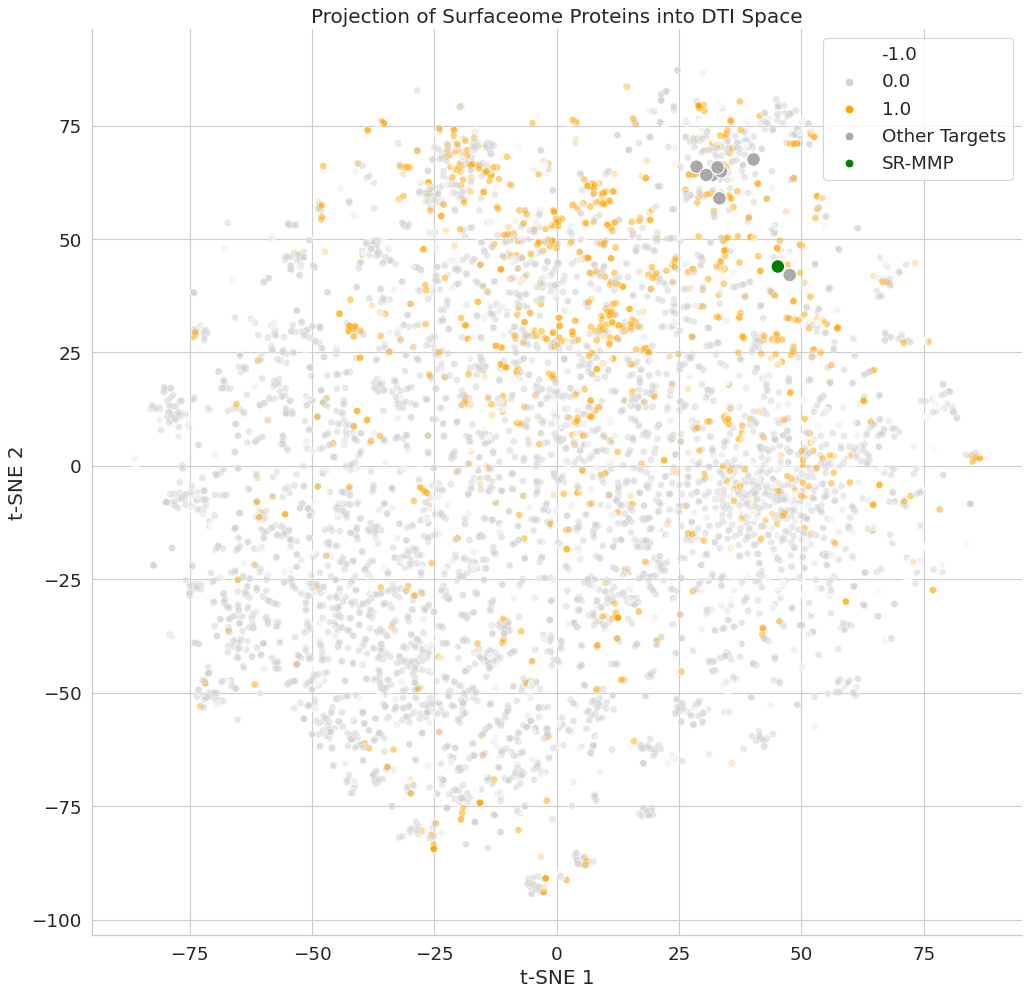

In [362]:
sns.set(style='whitegrid',font_scale=1.5)
plt.figure(figsize=(15, 15), dpi=80)

# style = ['Drug'] * n_drugs + ['Target'] * n_targets
size = [25] * n_drugs + [100] * n_targets
# style = np.concatenate([n_side_effects.values, np.array([0] * n_targets)])
# style = dist_measure
drug_style = df[target].replace(np.nan, -1)
target_style = [target if i == target else 'Other Targets' for i in task2sequence.keys()]


drug_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:n_drugs,0],
    't-SNE 2': embed_tsne[:n_drugs,1],
    'Class': drug_style
})

target_df = pd.DataFrame({
    't-SNE 1': embed_tsne[-n_targets:,0],
    't-SNE 2': embed_tsne[-n_targets:,1],
    'Class': target_style
})

sns.scatterplot(
    data = drug_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Class',
    s = 40,
    alpha = 0.5,
    palette = ['white','lightgrey','orange']
)
sns.scatterplot(
    data = target_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    s = 150,
    alpha = 1,
    hue = 'Class',
    palette = target_pal
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Projection of Surfaceome Proteins into DTI Space')
plt.legend()
sns.despine()
plt.show()

### Classification

In [359]:
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [360]:
from torch import sigmoid
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine

def sig_cosine_sim(x,y):
    cosine_similarity = CosineSimilarity(dim=0)
    return sigmoid(cosine_similarity(torch.from_numpy(x),torch.from_numpy(y))).numpy().item()

cosine_similarity = CosineSimilarity(dim=0)

In [248]:
for target in target_projections.keys():
    clsf_data = df[[target, 'smiles']].dropna()
    clsf_y = clsf_data[target].values
    print(f'pos: {clsf_y.sum()}, neg: {n_drugs - clsf_y.sum()}')

pos: 309.0, neg: 7522.0
pos: 237.0, neg: 7594.0
pos: 768.0, neg: 7063.0
pos: 300.0, neg: 7531.0
pos: 793.0, neg: 7038.0
pos: 350.0, neg: 7481.0
pos: 186.0, neg: 7645.0
pos: 942.0, neg: 6889.0
pos: 264.0, neg: 7567.0
pos: 372.0, neg: 7459.0
pos: 918.0, neg: 6913.0
pos: 423.0, neg: 7408.0


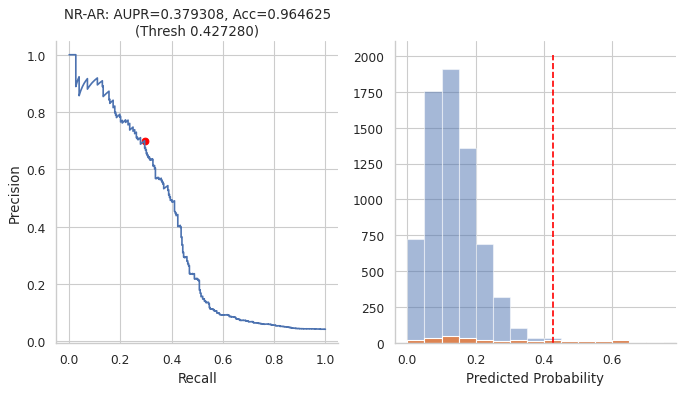

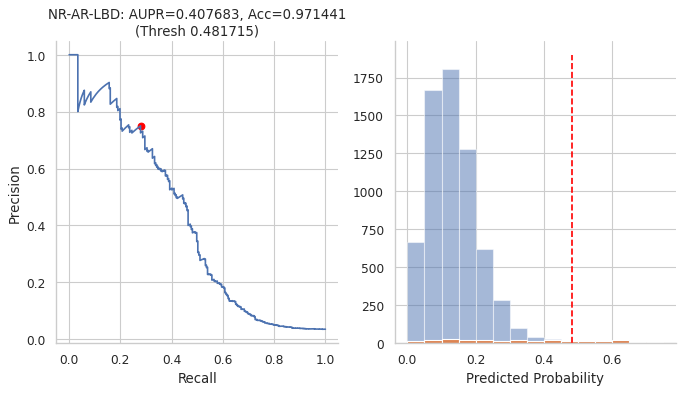

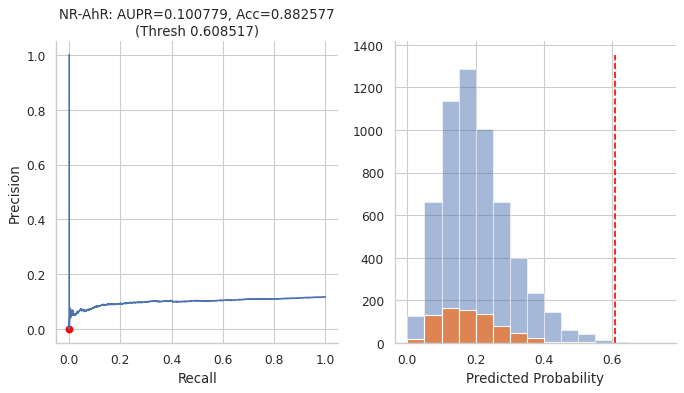

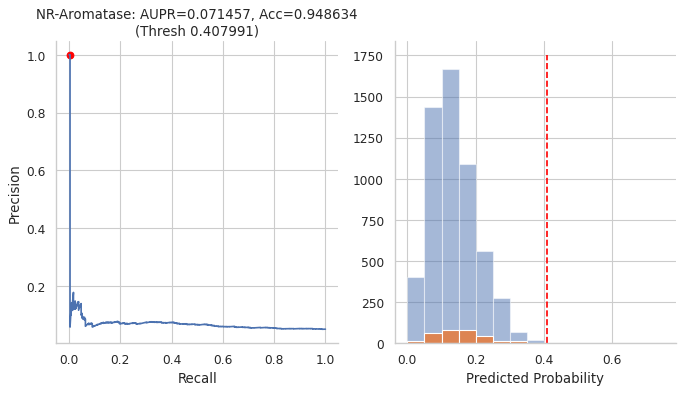

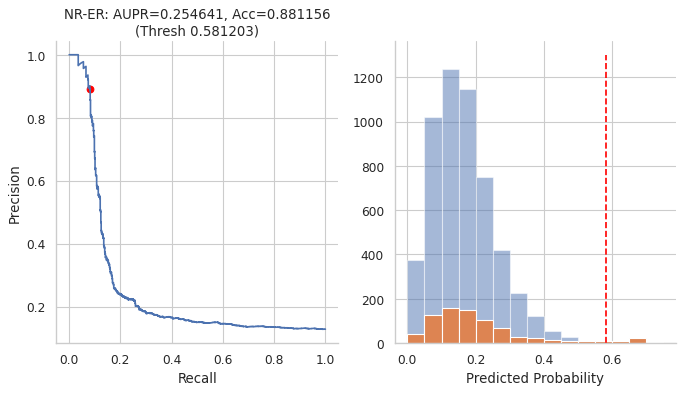

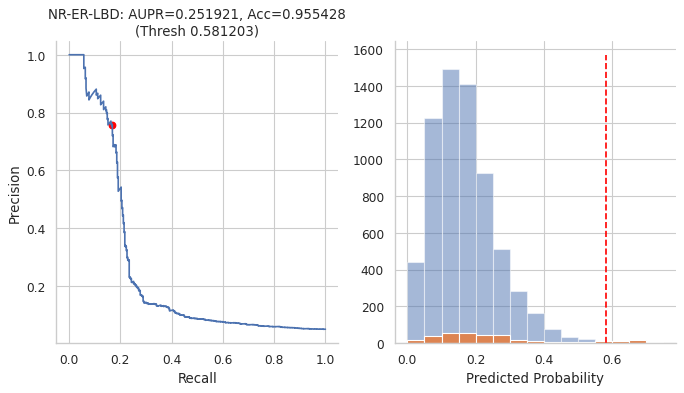

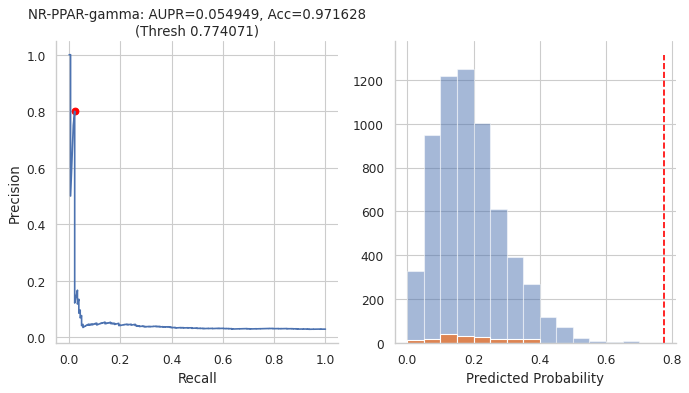

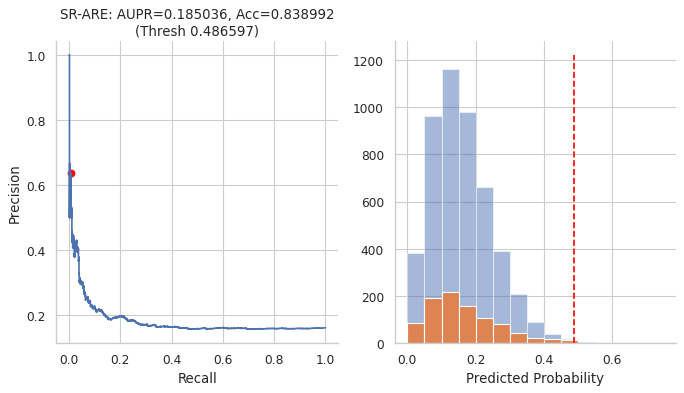

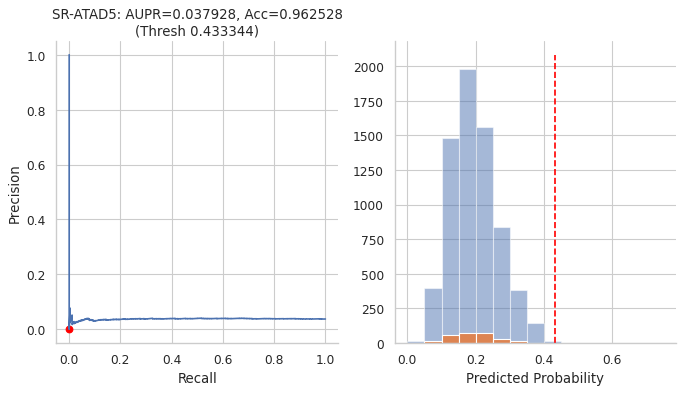

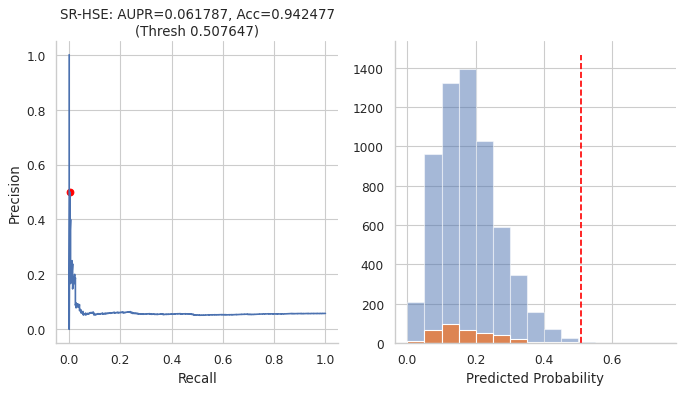

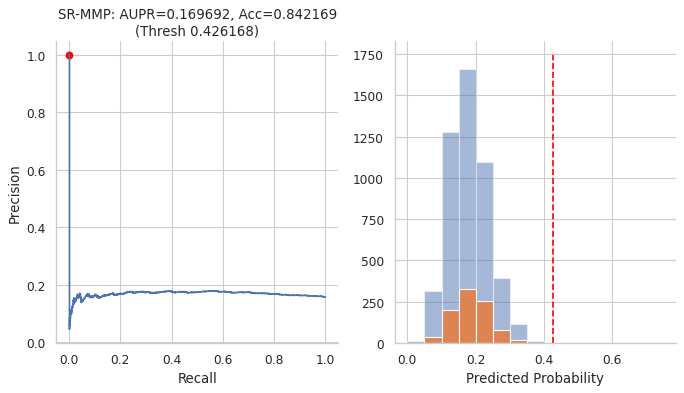

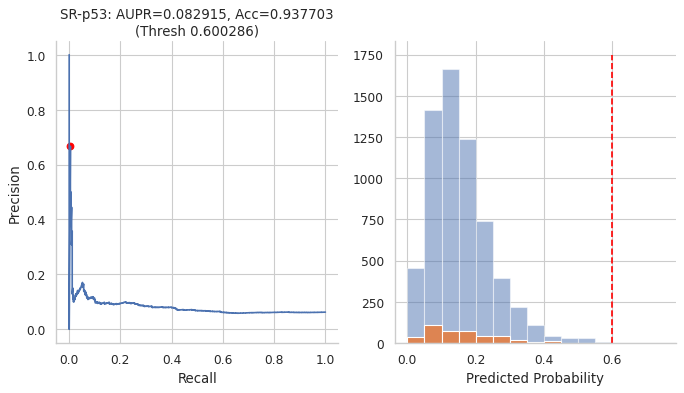

In [249]:
thresh = 0.5

for target in list(target_projections.keys()):
    labels = df[target].dropna()

    clsf_data = df[[target, 'smiles']].dropna()
    clsf_target = torch.from_numpy(target_projections[target])
    clsf_x = np.stack(list(drug_projections[i] for i in clsf_data['smiles']))
    clsf_y = clsf_data[target].values

    preds = torch.stack([cosine_similarity(torch.from_numpy(i), clsf_target) for i in clsf_x]).numpy()
    
    aupr = average_precision_score(clsf_y, preds)
    prc, rec, thr = precision_recall_curve(clsf_y, preds)
    
    i_best = 0
    t_best = 0
    t_acc_best = 0
    for i, t in enumerate(thr):
        t_acc = accuracy_score(clsf_y, (preds >= t))
        if t_acc > t_acc_best:
            i_best = i
            t_best = t
            t_acc_best = t_acc

    sns.set(style='whitegrid',font_scale=1)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
    
    ax0.plot(rec,prc)
    ax0.scatter(rec[i_best],prc[i_best],c='red')
    ax0.set_xlabel('Recall')
    ax0.set_ylabel('Precision')
    ax0.set_title(f'{target}: AUPR={aupr:3f}, Acc={t_acc_best:3f}\n(Thresh {t_best:3f})')
    
    ax1.hist(preds[clsf_y < 0.5],label='Negative',alpha=0.5,bins=np.arange(0,0.8,0.05))
    ax1.hist(preds[clsf_y > 0.5],label='Positive',alpha=1,bins=np.arange(0,0.8,0.05))
    ax1.vlines(t_best,0,ax1.get_ylim()[1],color='red',linestyle='--')
    ax1.set_xlabel('Predicted Probability')
    
    sns.despine()
    plt.show()

### Tox21 Yhao

In [4]:
t21_df_wide = pd.read_csv(f'{DATA_DIR}/../tox21/tox_data/data/tox21/tox21_assay_samples_all.tsv',sep='\t')

In [8]:
t21_yhao = t21_df_wide.pivot('compound_pubchem_cid','assay_name','assay_outcome').drop('CID_',axis=0)

In [10]:
t21_yhao.head()

assay_name,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,...,tox21-rxr-bla-agonist-p1,tox21-sbe-bla-agonist-p1,tox21-sbe-bla-antagonist-p1,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-tshr-agonist-p1,tox21-tshr-antagonist-p1,tox21-tshr-wt-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1
compound_pubchem_cid,,,,,,,,,,,,,,,,,,,,,
CID_10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID_10008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID_10009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID_10021362,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,...,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0
CID_10024,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [13]:
t21_atc = pd.read_csv(f'{DATA_DIR}/../tox21/tox_data/data/tox21/tox21_10k_library_atc_code.tsv',sep='\t').set_index('cid')

In [14]:
t21_atc.head()

,compound_name,atc_id,atc_id1,atc_id1_annotation,atc_id3,atc_id5
cid,,,,,,
CID_9552079,chlorhexidine,A01AB03,A,A: Alimentary tract,A01,A01AB
CID_2812,clotrimazole,A01AB18,A,A: Alimentary tract,A01,A01AB
CID_5743,dexamethasone,A01AC02,A,A: Alimentary tract,A01,A01AC
CID_9782,dexamethasone,A01AC02,A,A: Alimentary tract,A01,A01AC
CID_3607,hexetidine,A01AB12,A,A: Alimentary tract,A01,A01AB


In [23]:
with open(f'{DATA_DIR}/../tox21/tox_data/data/tox21/tox21_cmpd_ids.tsv','w+') as f:
    for cid in t21_yhao.index.unique():
        p,n = cid.split('_')
        f.write(f'{n}\n')

In [37]:
len(t21_yhao.index.unique()), len(t21_atc.index.unique()), len(set(t21_yhao.index).intersection(t21_atc.index))

(8747, 178, 178)

In [68]:
cid_smiles = pd.read_csv(f'{DATA_DIR}/../tox21/tox_data/data/tox21/pubchem_cid_search.tsv')
cid_smiles.cid = cid_smiles.cid.apply(lambda x: f'CID_{x}')
cid_smiles = cid_smiles.set_index('cid')

In [36]:
cid_smiles[['isosmiles']]

,isosmiles
cid,
CID_4,CC(CN)O
CID_6,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl
CID_11,C(CCl)Cl
CID_13,C1=CC(=C(C=C1Cl)Cl)Cl
CID_33,C(C=O)Cl
...,...
CID_91759530,C/C(=C/C(=[OH+])C)/[O-].C/C(=C/C(=[OH+])C)/[O-...
CID_91759531,C/C(=C/C(=[OH+])C)/[O-].C/C(=C/C(=[OH+])C)/[O-...
CID_91759532,C/C=C/C(=C)C1=C(CCCC1(C)C)C


In [35]:
cid_smiles.columns

Index(['cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [49]:
smile_projections = {}
smile_morgans = {}

for _, r in tqdm(cid_smiles.iterrows(),total=len(cid_smiles)):
    cid = r.name
    smi = r.isosmiles
    morg = drug_f(smi)
    smile_projections[cid] = model.drug_projector(morg.unsqueeze(0)).detach().cpu().numpy().squeeze()
    smile_morgans[cid] = morg.cpu().numpy().squeeze()
    
smile_projections_np = np.stack(list(smile_projections.values()))
smile_morgans_np = np.stack(list(smile_morgans.values()))

  0%|          | 0/8651 [00:00<?, ?it/s]

[13:21:28] WARNING: not removing hydrogen atom without neighbors
[13:21:28] WARNING: not removing hydrogen atom without neighbors
[13:21:28] Explicit valence for atom # 1 Si, 8, is greater than permitted
rdkit not found this smiles for morgan: None convert to all 0 features
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
[13:21:28] Explicit valence for atom # 3 Si, 8, is greater than permitted
rdkit not found this smiles for morgan: None convert to all 0 features
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType


In [79]:
to_drop = set(t21_atc.index).difference(cid_smiles.index)
t21_atc_drop = t21_atc.drop(to_drop,axis=0)

In [90]:
from sklearn.manifold import TSNE

atc_projections_np = np.stack([smile_projections[i] for i in t21_atc_drop.index])
atc_tsne = TSNE(
    metric="cosine"

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [83]:
t21_atc_drop.head()

,compound_name,atc_id,atc_id1,atc_id1_annotation,atc_id3,atc_id5
cid,,,,,,
CID_9552079,chlorhexidine,A01AB03,A,A: Alimentary tract,A01,A01AB
CID_2812,clotrimazole,A01AB18,A,A: Alimentary tract,A01,A01AB
CID_5743,dexamethasone,A01AC02,A,A: Alimentary tract,A01,A01AC
CID_9782,dexamethasone,A01AC02,A,A: Alimentary tract,A01,A01AC
CID_3607,hexetidine,A01AB12,A,A: Alimentary tract,A01,A01AB


In [98]:
def is_atc_class(df,c):
    return [c if r.atc_id1 == c else 'Other' for _,r in df.iterrows()]

In [107]:
t21_atc_drop.atc_id1.unique()

array(['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S',
       'V'], dtype=object)

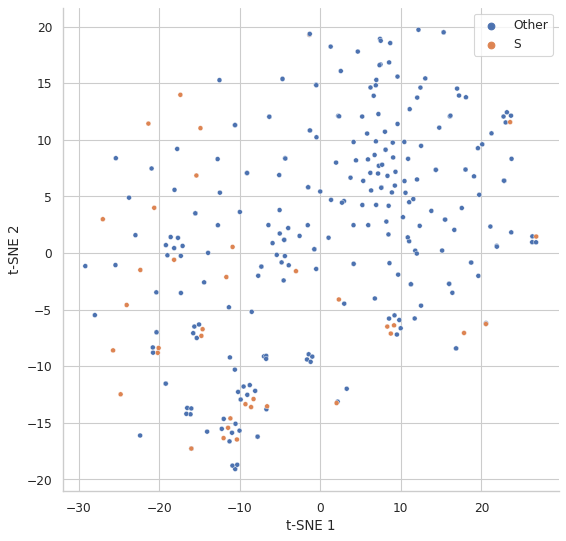

In [116]:
sns.set(style='whitegrid',font_scale=1)
plt.figure(figsize=(8, 8), dpi=80)

style = is_atc_class(t21_atc_drop, 'S')

plot_df = pd.DataFrame({
    't-SNE 1': atc_tsne[:,0],
    't-SNE 2': atc_tsne[:,1],
    'Class': style
})

sns.scatterplot(
    data = plot_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Class',
    s = 20,
    # palette = 'tab10'
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.title('Projection of Surfaceome Proteins into DTI Space')
plt.legend()
sns.despine()
plt.show()

In [93]:
from sklearn.metrics import silhouette_score

----

# Other Data Sets

In [318]:
dataset = pd.read_csv(f'{DATA_DIR}/toxcast_data.csv').drop_duplicates('smiles')

In [319]:
dataset

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,[O-]S(=O)(=O)C(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8593,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8594,[O-]S(=O)(=O)C(F)(F)F.CCC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8595,CCCCCCCCCCCCC1=CC=CC=C1S([O-])(=O)=O.CCCCCCCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

# Load model
device = torch.device(6)
drug_f = MorganFeaturizer().cuda(device)
target_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(drug_f.shape, target_f.shape, 1024)
model.load_state_dict(torch.load("best_models/reverse_margin_best_model.pt"))
model = model.to(device)

In [573]:
smile_projections = {}
smile_morgans = {}

for i, r in tqdm(dataset.iterrows(),total=len(dataset)):
    smile_projections[r.smiles] = model.drug_projector(drug_f(r.smiles).unsqueeze(0)).detach().cpu().numpy().squeeze()
    smile_morgans[r.smiles] = drug_f(r.smiles).detach().cpu().numpy()
    
smile_projections_np = np.stack(list(smile_projections.values()))
smile_morgans_np = np.stack(list(smile_morgans.values()))

  0%|          | 0/8583 [00:00<?, ?it/s]

---
## Drug Tox Profile Similarity

In [414]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import jaccard

cosine_similarity = CosineSimilarity(dim=0)

In [464]:
comb(len(dataset),2)

36829653.0

In [552]:
def jaccard_score(x,y):
    x = np.array(x).astype(bool)
    y = np.array(y).astype(bool)
    inter = (x & y)
    union = (x | y)
    if sum(union) == 0:
        return 0
    else:
        return sum(inter) / sum(union)

In [574]:
def choose_random_drug_pair(df, smile_column = 'smiles'):
    smiles = df[smile_column]
    dr1, dr2 = np.random.choice(smiles,2,replace=False)
    return pd.concat((df[df[smile_column] == dr1], df[df[smile_column] == dr2])).set_index(smile_column)

def compute_tox_similarity(df, distance_metric=jaccard_score):
    return distance_metric(df.iloc[0].values, df.iloc[1].values)

def compute_our_similarity(df, smile_projections = smile_projections):
    dr1, dr2 = df.index
    return cosine_similarity(torch.from_numpy(smile_projections[dr1]), torch.from_numpy(smile_projections[dr2])).item()

tox_sims = []
our_sims = []
mor_sims = []

for _ in tqdm(range(50000)):
    xdf = choose_random_drug_pair(dataset).dropna(axis=1)
    if xdf.shape[1] > 50:
        our_sims.append(compute_our_similarity(xdf))
        mor_sims.append(compute_our_similarity(xdf, smile_morgans))
        ts = compute_tox_similarity(xdf)
        if np.isnan(ts):
            break
        tox_sims.append(ts)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [575]:
tox_sims_np = np.array(tox_sims)
our_sims_np = np.array(our_sims)
mor_sims_np = np.array(mor_sims)

In [595]:
nz_mask = (tox_sims_np > 0)
nz_ours = our_sims_np[nz_mask]
nz_mor = mor_sims_np[nz_mask]
nz_tox = tox_sims_np[nz_mask]

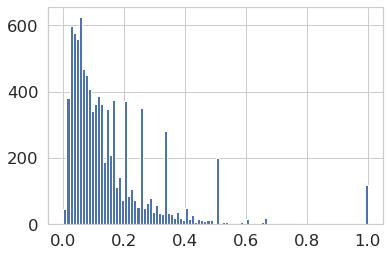

In [602]:
plt.hist(nz_tox,bins=np.arange(0,1.01,0.01))
plt.show()

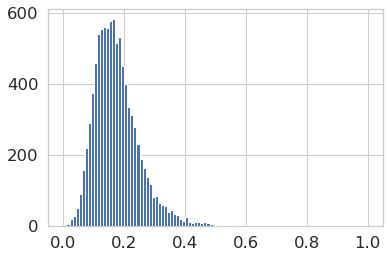

In [603]:
plt.hist(nz_ours,bins=np.arange(0,1.01,0.01))
plt.show()

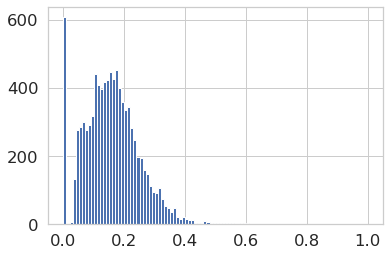

In [604]:
plt.hist(nz_mor,bins=np.arange(0,1.01,0.01))
plt.show()

In [596]:
from scipy.stats import pearsonr, spearmanr

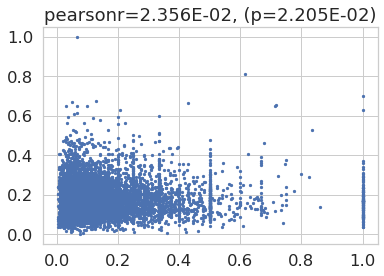

In [600]:
r,p = pearsonr(nz_tox, nz_ours)
plt.scatter(nz_tox, nz_ours,s=5)
plt.title(f'pearsonr={r:.3E}, (p={p:.3E})')
plt.show()

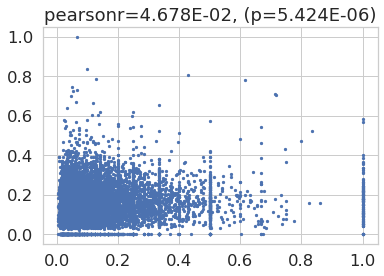

In [601]:
r,p = pearsonr(nz_tox, nz_mor)
plt.scatter(nz_tox, nz_mor,s=5)
plt.title(f'pearsonr={r:.3E}, (p={p:.3E})')
plt.show()

---
## t-SNE and Clustering

In [322]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

data_tsne = TSNE(
    metric="cosine"
).fit_transform(smile_projections_np)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [335]:
random_projections = np.random.random((smile_projections_np.shape))
morgan_fingerprints = np.stack([drug_f(r.smiles).cpu().numpy() for (_,r) in dataset.iterrows()])

silscores = {}

for variable in tqdm(dataset.columns[1:],total=dataset.shape[1]-1):
    keep_mask = ~dataset[variable].isna()
    
    style = dataset[keep_mask][variable]
    silscore_om = silhouette_score(smile_projections_np[keep_mask], style)
    silscore_morgan = silhouette_score(morgan_fingerprints[keep_mask], style)
    silscore_rand = silhouette_score(random_projections[keep_mask], style)
    
    silscore_tup = (silscore_om, silscore_morgan, silscore_rand)
    silscores[variable] = silscore_tup
    
    if (silscore_tup[0] >= 0.1) or (silscore_tup[1] >= 0.1) or (silscore_tup[2] >= 0.1):
        print(f"{variable}: ours={silscore_tup[0]:4f}, morgan={silscore_tup[1]:4f}, random={silscore_tup[2]:4f}")

  0%|          | 0/617 [00:00<?, ?it/s]

ATG_AR_TRANS_up: ours=0.142329, morgan=0.085293, random=-0.000536
ATG_CAR_TRANS_dn: ours=0.071369, morgan=0.102445, random=-0.000736
ATG_GRE_CIS_up: ours=0.095401, morgan=0.100546, random=0.000510
ATG_GR_TRANS_up: ours=0.130145, morgan=0.117468, random=0.000298
BSK_CASM3C_LDLR_up: ours=0.079961, morgan=0.134624, random=0.000149
BSK_CASM3C_VCAM1_up: ours=0.044338, morgan=0.124357, random=0.002153
BSK_LPS_Eselectin_up: ours=0.162384, morgan=0.095809, random=-0.000445
NVS_NR_rMR: ours=0.196692, morgan=0.066186, random=0.000886
TOX21_AR_BLA_Agonist_ch2: ours=0.122906, morgan=0.084779, random=0.000032
TOX21_AR_BLA_Agonist_ratio: ours=0.115851, morgan=0.083220, random=0.000296
TOX21_AR_LUC_MDAKB2_Agonist: ours=0.132333, morgan=0.102746, random=0.000558
TOX21_AutoFluor_HEPG2_Cell_green: ours=0.141609, morgan=0.108281, random=-0.001322
TOX21_AutoFluor_HEPG2_Media_green: ours=0.142745, morgan=0.101697, random=-0.001265
TOX21_GR_BLA_Agonist_ch2: ours=0.125195, morgan=0.125874, random=-0.000261
T

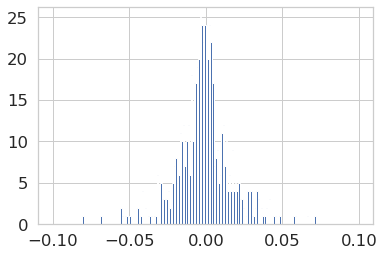

In [370]:
us = np.array([i[0] for i in silscores.values()])
morgan = np.array([i[1] for i in silscores.values()])
plt.hist(us-morgan,bins=np.arange(-.1,0.1,0.001))
plt.show()

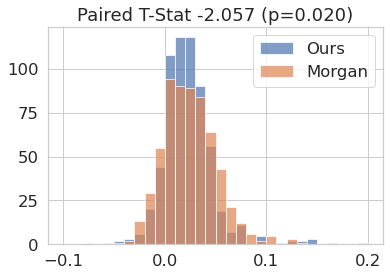

In [368]:
from scipy.stats import ttest_rel

tstat, pval = ttest_rel([i[0] for i in silscores.values()], [i[1] for i in silscores.values()],alternative='less')

plt.hist([i[0] for i in silscores.values()],label='Ours',alpha=0.7,bins=np.arange(-0.1,0.2,0.01))
plt.hist([i[1] for i in silscores.values()],label='Morgan',alpha=0.7,bins=np.arange(-0.1,0.2,0.01))
plt.title(f"Paired T-Stat {tstat:.3f} (p={pval:.3f})")
plt.legend()
plt.show()

In [350]:
sns.set(style='whitegrid',font_scale=1.5)
plt.figure(figsize=(15, 15), dpi=80)

i = 1
variable = dataset.columns[i]

style = dataset[variable]
silscore = silhouette_score(data_tsne, style)

plot_df = pd.DataFrame({
    't-SNE 1': data_tsne[:,0],
    't-SNE 2': data_tsne[:,1],
    variable: style
})

sns.scatterplot(
    data = plot_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = variable,
    s = 30,
    alpha = 1,
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'Silhouette Score: {silscore:3f}')
# plt.legend()
sns.despine()
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<Figure size 1200x1200 with 0 Axes>